In [1]:
import numpy as np
import zipfile as zf
import matplotlib.pyplot as plt
import pickle, csv, struct, h5py
from subprocess import call

In [2]:
def writeDiphaInput(filename, base_map):
    
    file = open(filename, "wb")
    
    file.write(struct.pack('<q', 8067171840))
    file.write(struct.pack('<q', 1))
    file.write(struct.pack('<q', base_map.size))
    file.write(struct.pack('<q', base_map.ndim))
    
    for n in base_map.shape: 
        file.write(struct.pack('<q', n))
    
    for v in base_map.flatten():
        file.write(struct.pack('<d', v))
    
    file.close()
    
    return

In [3]:
def readPersistenceDiagram(file, dim):
    
    birth = np.empty(0, dtype = float)
    death = np.empty(0, dtype = float)

    file.read(24)
    
    for s in iter(lambda: file.read(24), b''):
        
        d = int(struct.unpack('<q', s[:8])[0])
        
        if d == dim:
            
            birth = np.append(birth, struct.unpack('<d', s[8:16])[0])
            death = np.append(death, struct.unpack('<d', s[-8:])[0])
    
    return [birth, death]

In [4]:
#def computePersistenceDiagram(datapath):

In [5]:
dset = h5py.File('./JetImages/jet-images_Mass60-100_pT250-300_R1.25_Pix25.hdf5','r')
wdir = '/Volumes/ramdisk'

sigcount = 0
bkgcount = 0
totnum = 4000

pd_birth = [None] * totnum
pd_death = [None] * totnum
image = [None] * totnum
jet_delta_R = np.zeros(totnum)
jet_eta = np.zeros(totnum)
jet_mass = np.zeros(totnum)
jet_phi = np.zeros(totnum)
jet_pt = np.zeros(totnum)
signal = np.zeros(totnum)
tau_1 = np.zeros(totnum)
tau_2 = np.zeros(totnum)
tau_21 = np.zeros(totnum)
tau_3 = np.zeros(totnum)
tau_32 = np.zeros(totnum)

for i, sig in enumerate(dset['signal']):

    if (sig == 1.0) and (sigcount < totnum/2) and (60<dset['jet_mass'][i]<95):
        
        sigcount += 1
        #norm = np.linalg.norm(dset['image'][i])
        writeDiphaInput(wdir+'/tmp.dat', dset['image'][i])
        call('./dipha '+wdir+'/tmp.dat '+wdir+'/sig'+str(sigcount)+'.pd', shell=True)
        pd_file = open(wdir+'/sig'+str(sigcount)+'.pd','rb')
        pd = readPersistenceDiagram(pd_file, 1)
        pd_file.close()
        pd_birth[2*sigcount-1] = pd[0]
        pd_death[2*sigcount-1] = pd[1]
        image[2*sigcount-1] = dset['image'][i]
        jet_delta_R[2*sigcount-1] = dset['jet_delta_R'][i]
        jet_eta[2*sigcount-1] = dset['jet_eta'][i]
        jet_mass[2*sigcount-1] = dset['jet_mass'][i]
        jet_phi[2*sigcount-1] = dset['jet_phi'][i]
        jet_pt[2*sigcount-1] = dset['jet_pt'][i]
        signal[2*sigcount-1] = dset['signal'][i]
        tau_1[2*sigcount-1] = dset['tau_1'][i]
        tau_2[2*sigcount-1] = dset['tau_2'][i]
        tau_21[2*sigcount-1] = dset['tau_21'][i]
        tau_3[2*sigcount-1] = dset['tau_3'][i]
        tau_32[2*sigcount-1] = dset['tau_32'][i]
        
        if sigcount%1000 == 0: 
            call('rm '+wdir+'/sig*', shell=True)
        
    elif (sig == 0.0) and (bkgcount < totnum/2) and (60<dset['jet_mass'][i]<95):
        
        bkgcount += 1
        #norm = np.linalg.norm(dset['image'][i])
        writeDiphaInput(wdir+'/tmp.dat', dset['image'][i])
        call('./dipha '+wdir+'/tmp.dat '+wdir+'/bkg'+str(bkgcount)+'.pd', shell=True)
        pd_file = open(wdir+'/bkg'+str(bkgcount)+'.pd','rb')
        pd = readPersistenceDiagram(pd_file, 1)
        pd_file.close()
        pd_birth[2*bkgcount-2] = pd[0]
        pd_death[2*bkgcount-2] = pd[1]
        image[2*bkgcount-2] = dset['image'][i]
        jet_delta_R[2*bkgcount-2] = dset['jet_delta_R'][i]
        jet_eta[2*bkgcount-2] = dset['jet_eta'][i]
        jet_mass[2*bkgcount-2] = dset['jet_mass'][i]
        jet_phi[2*bkgcount-2] = dset['jet_phi'][i]
        jet_pt[2*bkgcount-2] = dset['jet_pt'][i]
        signal[2*bkgcount-2] = dset['signal'][i]
        tau_1[2*bkgcount-2] = dset['tau_1'][i]
        tau_2[2*bkgcount-2] = dset['tau_2'][i]
        tau_21[2*bkgcount-2] = dset['tau_21'][i]
        tau_3[2*bkgcount-2] = dset['tau_3'][i]
        tau_32[2*bkgcount-2] = dset['tau_32'][i]
        
        if bkgcount%1000 == 0: 
            call('rm '+wdir+'/bkg*', shell=True)
        
    if int(bkgcount + sigcount) == totnum:
        break

dset.close()
dset_out = h5py.File('./PersistenceDiagrams/jetPDs_Mass60-95_pT250-300_R1.25_Pix25.hdf5','w')
group = dset_out.create_group('persisdgm')
dt = h5py.special_dtype(vlen=np.dtype('float32'))
dset_out.create_dataset('pd_birth',data=pd_birth, dtype = dt)
dset_out.create_dataset('pd_death',data=pd_death, dtype = dt)
dset_out.create_dataset('image',data=image)
dset_out.create_dataset('jet_delta_R',data=jet_delta_R)
dset_out.create_dataset('jet_eta',data=jet_eta)
dset_out.create_dataset('jet_mass',data=jet_mass)
dset_out.create_dataset('jet_phi',data=jet_phi)
dset_out.create_dataset('jet_pt',data=jet_pt)
dset_out.create_dataset('signal',data=signal)
dset_out.create_dataset('tau_1',data=tau_1)
dset_out.create_dataset('tau_2',data=tau_2)
dset_out.create_dataset('tau_21',data=tau_21)
dset_out.create_dataset('tau_3',data=tau_3)
dset_out.create_dataset('tau_32',data=tau_32)
dset_out.close()

In [7]:
x_bkg = np.array([])
y_bkg = np.array([])

x_sig = np.array([])
y_sig = np.array([])

dset_bkg = zf.ZipFile('./PersistenceDiagrams/bkg1.zip', 'r')
dset_sig = zf.ZipFile('./PersistenceDiagrams/sig1.zip', 'r')

for i in range(3,4):
    
    file_bkg = dset_bkg.open('bkg'+str(i+1)+'.pd')
    file_sig = dset_sig.open('sig'+str(i+1)+'.pd')
    
    persis_bkg = readPersistenceDiagram(file_bkg, 1)
    persis_sig = readPersistenceDiagram(file_sig, 1)
    
    file_bkg.close()
    file_sig.close()
        
    x_bkg = np.append(x_bkg, persis_bkg[0])
    y_bkg = np.append(y_bkg, persis_bkg[1])
        
    x_sig = np.append(x_sig, persis_sig[0])
    y_sig = np.append(y_sig, persis_sig[1])

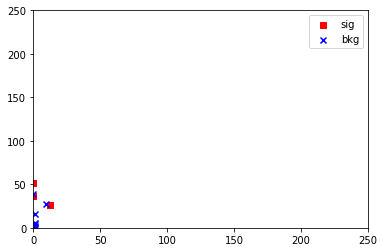

In [8]:
plt.scatter(x_sig, y_sig, c='r', marker='s', label='sig')
plt.scatter(x_bkg, y_bkg, c='b', marker='x', label='bkg')
plt.xlim(0, 250)
plt.ylim(0, 250)
plt.legend(loc='upper right')
plt.show()

In [3]:
dset_in = h5py.File('./JetImages/jet-images_Mass60-100_pT250-300_R1.25_Pix25.hdf5','r')

In [9]:
list(dset_in.keys())

['image',
 'jet_delta_R',
 'jet_eta',
 'jet_mass',
 'jet_phi',
 'jet_pt',
 'signal',
 'tau_1',
 'tau_2',
 'tau_21',
 'tau_3',
 'tau_32']